In [2]:
print("Hello Charles, notebook opérationnel 🚀")

Hello Charles, notebook opérationnel 🚀


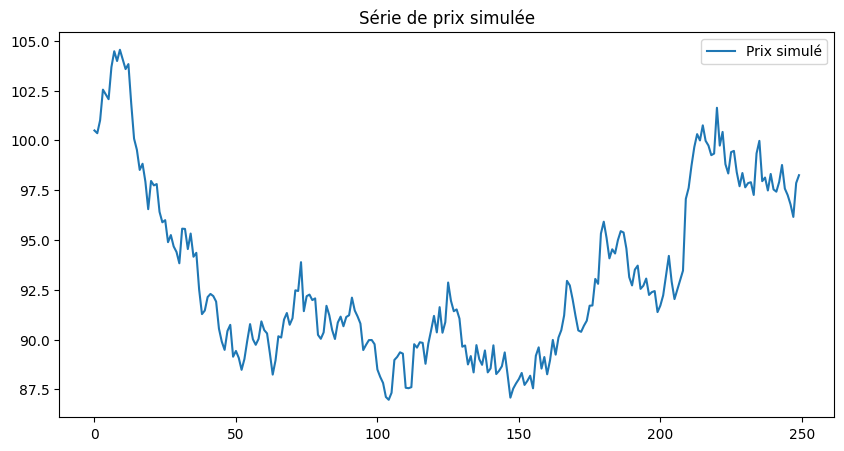

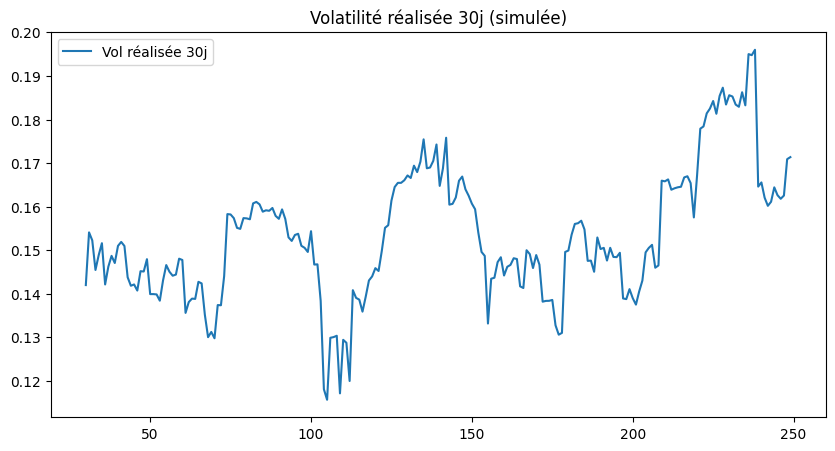

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Générer des prix factices (simulation de marche aléatoire)
np.random.seed(42)
returns = np.random.normal(0, 0.01, 250)  # 250 jours de "rendements"
prices = 100 * (1 + returns).cumprod()

# Calcul de la vol réalisée 30j
log_returns = np.log(pd.Series(prices) / pd.Series(prices).shift(1))
rv30 = log_returns.rolling(30).std() * np.sqrt(252)

# Afficher résultats
plt.figure(figsize=(10,5))
plt.plot(prices, label="Prix simulé")
plt.title("Série de prix simulée")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(rv30, label="Vol réalisée 30j")
plt.title("Volatilité réalisée 30j (simulée)")
plt.legend()
plt.show()